### Sea Surface Temperature Forecasting with SHRED
This notebook demonstrates how increasing the quantity of sensors and using proper sensor placement (location) can substantially improve the accuracy (i.e., decrease the error) of forecasting the full state of a system at a point in time using SHRED. This notebook also generates a GIF/image sequence of full states and a plot of an individual node's temperature change to demonstrate how a SHRED model and forecaster should be trained to effectively capture the patterns of a spatiotemporal dataset and continue forecasting those patterns with little error.

This example uses a 1990 sea surface temperature dataset, which is also the same one featured in the PySHRED documentation and tutorial.

In [1]:
# Import all dependencies
import pyshred
from pyshred import *
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


# Initialize our dataset
sst_dataset = xr.open_dataset("sst.wkmean.1990-present.nc")
mask_dataset = xr.open_dataset("lsmask.nc")

data = sst_dataset["sst"].values
mask = np.squeeze(mask_dataset["mask"].values)

data[:, mask==0] = 0

# data stores an entire SST map for every index, where indices are timesteps in weeks

c:\myapps\Anaconda\envs\shred-ll-env\lib\site-packages\pysindy\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


Define a starting and ending week of data to use for the first demonstration, which compares the performance of a SHRED model trained on sparse vs more numerous sensor data on a limited spatiotemporal dataset.

In [2]:
# This represents how much of our entire dataset we want to work with
start_week = 0 # default
end_week = int(input(f"Last week to include in data (size is {len(data)}): "))

Plot the entire sea surface temperature map at the first and last week chosen. Though the period of this dataset's cyclical patterns are closer to 52 weeks (a year) and not the entire timespan (potentially ~1727 weeks), it's still a good idea to see what the beginning and end of the entire selected dataset looks like for comparison sake.

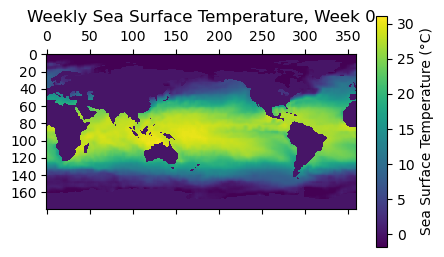

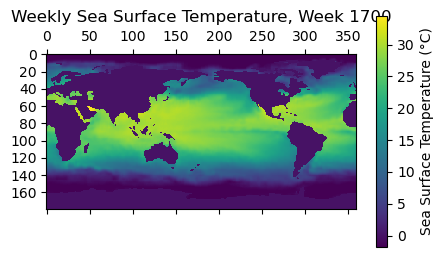

In [3]:
# Let's visualize the first and last week of data!
# Visually, this should give us an idea of what the trajectory of our data looks like
fig, ax = plt.subplots(figsize=(5, 4))
im1 = ax.matshow(data[start_week])  # 1. Capture the mappable object here
ax.set_title(f"Weekly Sea Surface Temperature, Week {start_week}")
fig.colorbar(im1, ax=ax, label="Sea Surface Temperature (°C)", shrink=0.75)

fig, ax = plt.subplots(figsize=(5, 4))
im2 = ax.matshow(data[end_week]) 
ax.set_title(f"Weekly Sea Surface Temperature, Week {end_week}")
fig.colorbar(im2, ax=ax, label="Sea Surface Temperature (°C)", shrink=0.75)

Set up the sensor locations: one "sparse" vector to store a few tuples of coordinates, and a "dense" vector to capture data at more coordinates.

In [4]:
# Used to compare performance of using different amounts of sensors
# in well placed locations.
sparse_locations = [(75, 165), (90, 225), (120, 175)]
dense_locations = [(75, 165), (90, 225), (120, 175), (115, 255), (110, 225), (100, 100)]

Then define an "isolated dataset" with which the first round of SHRED training and demonstration will be run on.

In [5]:
# Isolating half of the dataset to see if the SHRED forecast can predict beyond the test split of the whole dataset
# This will be used for both sparse and numerous sensor location tests
data_length = end_week // 2
isolated_data = data[:data_length]

Initialize two DataManagers objects: one will store only the data from the sparse sensor selection, and the other will contain the dense, "fuller-picture" data from the dense sensor selection.

In [6]:
# Define ratios
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# Initialize sparse data manager
sparse_manager = DataManager(
    lags=52, # 52 weeks means short-term memory used to train SHRED model's LSTM will be a year long
    train_size=TRAIN_RATIO, 
    val_size=VAL_RATIO,
    test_size=TEST_RATIO,
)

sparse_manager.add_data(
    data=isolated_data,
    id="My_Sparse_SST",
    stationary=sparse_locations,
    compress=False
)

# Initialize dense data manager
dense_manager = DataManager(
    lags=52,
    train_size=TRAIN_RATIO,
    val_size=VAL_RATIO,
    test_size=TEST_RATIO,
)  

dense_manager.add_data(
    data=isolated_data,
    id="My_Dense_SST",
    stationary=dense_locations,
    compress=False
)

Visualize the sensor datatables.

In [7]:
# Preview sparse and dense sensor measurements
sparse_manager.sensor_measurements_df

,My_Sparse_SST-0,My_Sparse_SST-1,My_Sparse_SST-2
0,27.830000,25.709999,22.320000
1,27.539999,25.779999,22.289999
2,27.250000,25.289999,23.549999
3,27.129999,25.500000,22.969999
4,27.019999,25.670000,23.740000
...,...,...,...
845,26.889999,25.000000,22.910000
846,26.840000,25.180000,23.049999
847,26.879999,25.480000,23.160000
848,27.099998,26.500000,23.170000


In [8]:
# Preview sparse and dense sensor measurements
dense_manager.sensor_measurements_df

,My_Dense_SST-0,My_Dense_SST-1,My_Dense_SST-2,My_Dense_SST-3,My_Dense_SST-4,My_Dense_SST-5
0,27.830000,25.709999,22.320000,24.500000,27.410000,28.059999
1,27.539999,25.779999,22.289999,24.820000,27.349998,27.750000
2,27.250000,25.289999,23.549999,24.719999,27.299999,27.900000
3,27.129999,25.500000,22.969999,24.189999,27.570000,28.129999
4,27.019999,25.670000,23.740000,24.209999,27.019999,28.199999
...,...,...,...,...,...,...
845,26.889999,25.000000,22.910000,25.320000,28.309999,29.459999
846,26.840000,25.180000,23.049999,24.959999,28.410000,29.449999
847,26.879999,25.480000,23.160000,24.959999,28.320000,29.209999
848,27.099998,26.500000,23.170000,24.629999,28.580000,28.769999


Now prepare two different SHRED models using the sparse and dense DataManager instances.

In [9]:
# Prepare sparse and dense train test val splits
sparse_train, sparse_val, sparse_test = sparse_manager.prepare()
dense_train, dense_val, dense_test = dense_manager.prepare()

# You can even define your own decoder and LSTM models here.
# Remember that the coupling is super flexible, so long as
# LSTM/temporal model outputs a final hidden state that can
# be used by the decoder model to output a full state space
sparse_shred = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster="LSTM_Forecaster"
)

dense_shred = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster="LSTM_Forecaster"
)

# Fit sparse and dense SHRED models, set epochs to 2 for brevity, increase if preferred
epoch_limit = 2

sparse_val_errors = sparse_shred.fit(
    train_dataset=sparse_train,
    val_dataset=sparse_val,
    num_epochs=epoch_limit,
    verbose=False
)

dense_val_errors = dense_shred.fit(
    train_dataset=dense_train,
    val_dataset=dense_val,
    num_epochs=epoch_limit,
    verbose=False
)

print(f"Sparse SHRED model's validation error: {sparse_val_errors}\nDense SHRED model's validation error: {dense_val_errors}\n")

Fitting SHRED...
Fitting SHRED...
Sparse SHRED model's validation error: [0.04568245 0.04317618]
Dense SHRED model's validation error: [0.04727291 0.04409426]



Evaluate the sparse and dense shred models with MSE.

In [10]:
sparse_train_mse = sparse_shred.evaluate(dataset=sparse_train)
sparse_val_mse = sparse_shred.evaluate(dataset=sparse_val)
sparse_test_mse = sparse_shred.evaluate(dataset=sparse_test)

dense_train_mse = dense_shred.evaluate(dataset=dense_train)
dense_val_mse = dense_shred.evaluate(dataset=dense_val)
dense_test_mse = dense_shred.evaluate(dataset=dense_test)

print("Sparse Train MSE: ", sparse_train_mse)
print("Sparse Validation MSE: ", sparse_val_mse)
print("Sparse Test MSE: ", sparse_test_mse)

print("Dense Train MSE: ", dense_train_mse)
print("Dense Validation MSE: ", dense_val_mse)
print("Dense Test MSE: ", dense_test_mse)


Sparse Train MSE:  0.03946807555487473
Sparse Validation MSE:  0.043176178399600584
Sparse Test MSE:  0.044354671614015975
Dense Train MSE:  0.04023357573642883
Dense Validation MSE:  0.04409425636574074
Dense Test MSE:  0.045278501157407405


SHRED does two things:

Encoder – encodes the sensor readings into a latent state: same timespan, increased features

Decoder – expands the latent state back into the full state

For forecasting:
Use a small model to predict future sensor readings, where the testing datasets' (defined in previous step where training, validation, testing data was prepared) sensor data are ground truths for the forecasted sensor data, and the full states corresponding to that sensor data are ground truths for the final, full state reconstruction using the forecasted sensor data.

Then, feed those predicted sensor readings through SHRED's decoder to reconstruct the full future state.

In [11]:
sparse_engine = SHREDEngine(sparse_manager, sparse_shred)
dense_engine = SHREDEngine(dense_manager, dense_shred)

sparse_test_latents = sparse_engine.sensor_to_latent(sparse_manager.test_sensor_measurements)
sparse_val_latents = sparse_engine.sensor_to_latent(sparse_manager.val_sensor_measurements)

dense_test_latents = dense_engine.sensor_to_latent(dense_manager.test_sensor_measurements)
dense_val_latents = dense_engine.sensor_to_latent(dense_manager.val_sensor_measurements)

# Set up the forecaster and seed it with a bunch of the validation
# dataset's latent states.
sparse_init_latents = sparse_val_latents[-sparse_shred.latent_forecaster.seed_length:]
dense_init_latents = dense_val_latents[-dense_shred.latent_forecaster.seed_length:]

h = len(sparse_manager.test_sensor_measurements) # Testing the forecaster requires us to use h "future steps" where h is the length of the testing data, which is what we aim to predict with sensor forecaster initially.

# This is the big step: creating H steps of forecasted latents that are directly
# comparable to the ground truth testing latents. In other words, this first "predicts"
# what the test dataset's latents should be, to then compare those latents to the actual
# testing dataset's latents.
test_latent_from_forecaster = sparse_engine.forecast_latent(h=h, init_latents=sparse_init_latents)
dense_latents_from_forecaster = dense_engine.forecast_latent(h=h, init_latents=dense_init_latents)

mse = np.mean((test_latent_from_forecaster - sparse_test_latents)**2)
mse_2 = np.mean((dense_latents_from_forecaster - dense_test_latents)**2)

print("MSE of sparse test latents from forecasted latents: ", mse)
print("MSE of dense test latents from forecasted latents: ", mse_2)

MSE of sparse test latents from forecasted latents:  0.00025766584
MSE of dense test latents from forecasted latents:  0.0001984715


After running the MSE tests from above, it is more than likely that the dense test latents that are generated will be more accurate (lower MSE) than the MSE of sparse test latents. That's because the latents used to seed the sensor forecaster with the dense sensor data are more data-rich than the sparse sensor data, making the result closer to the real sensor data.

Now run reconstruction and forecasting.

Sparse MSE:  0.0030074061
Dense MSE:  0.000871966


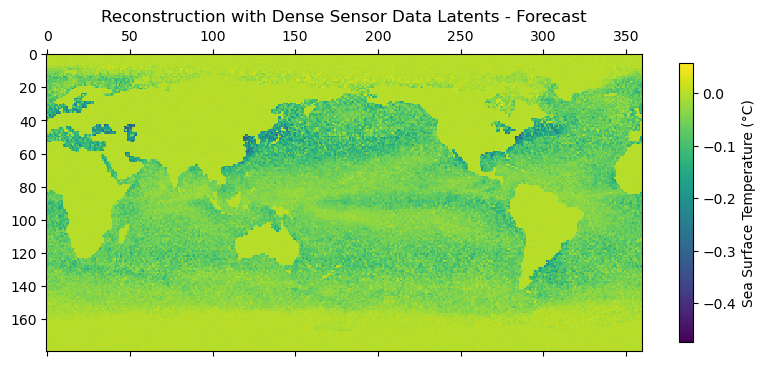

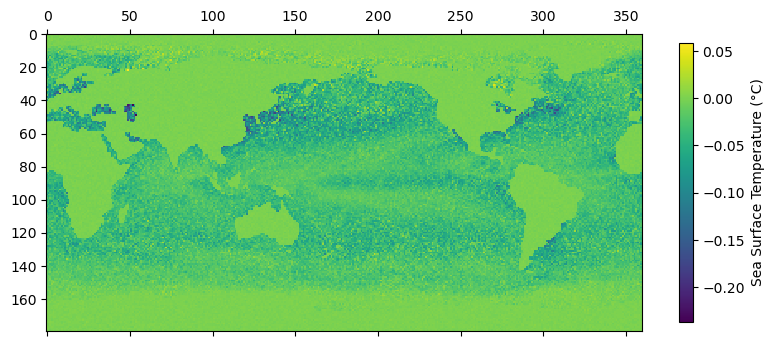

In [12]:
sparse_test_reconstruction = sparse_engine.decode(sparse_test_latents)
sparse_test_forecast = sparse_engine.decode(test_latent_from_forecaster)

dense_test_reconstruction = dense_engine.decode(dense_test_latents)
dense_test_forecast = dense_engine.decode(dense_latents_from_forecaster)

print("Sparse MSE: ", np.mean((sparse_test_reconstruction['My_Sparse_SST'][0] - sparse_test_forecast['My_Sparse_SST'][0])**2))
print("Dense MSE: ", np.mean((dense_test_reconstruction['My_Dense_SST'][0] - dense_test_forecast['My_Dense_SST'][0])**2))

plt.matshow(sparse_test_reconstruction['My_Sparse_SST'][0] - sparse_test_forecast['My_Sparse_SST'][0])
plt.title("Reconstruction with Sparse Sensor Data Latents - Forecast")
plt.colorbar(label="Sea Surface Temperature (°C)", shrink=0.75)

plt.title("Reconstruction with Dense Sensor Data Latents - Forecast")
plt.matshow(dense_test_reconstruction['My_Dense_SST'][0] - dense_test_forecast['My_Dense_SST'][0])
plt.colorbar(label="Sea Surface Temperature (°C)", shrink=0.75)


Now expand the demonstration to the full scope of the dataset, using the trained SHRED models to evaluate whether sparse or dense sensor usage is more optimal for reconstructing an accurate future state. Then, the optimal model will be used to generate a video of forecasted full states.

In [13]:
# First, get the latents from the future sensor measurements (after the isolated data)
# Then, use the decoder to decode those latents into full state spaces.
# Then, get the MSE between those latents and the actual future sensor measurements.

future_manager_sparse = DataManager(
    lags=52,
    train_size=TRAIN_RATIO,
    val_size=VAL_RATIO,
    test_size=TEST_RATIO
)

future_manager_dense = DataManager(
    lags=52,
    train_size=TRAIN_RATIO,
    val_size=VAL_RATIO,
    test_size=TEST_RATIO
)

future_manager_sparse.add_data(
    data=data,
    id="Sparse_Future_SST",
    stationary=sparse_locations,
)

future_manager_dense.add_data(
    data=data,
    id="Dense_Future_SST",
    stationary=dense_locations,
)

# Prepare data and begin training
sparse_train, sparse_val, sparse_test = future_manager_sparse.prepare()

epoch_limit = 10
sparse_val_errors = sparse_shred.fit(
    train_dataset=sparse_train,
    val_dataset=sparse_val,
    num_epochs=epoch_limit,
    verbose=False
)

dense_train, dense_val, dense_test = future_manager_dense.prepare()

epoch_limit = 10
dense_val_errors = dense_shred.fit(
    train_dataset=dense_train,
    val_dataset=dense_val,
    num_epochs=epoch_limit,
    verbose=False
)

sparse_engine = SHREDEngine(future_manager_sparse, sparse_shred)
dense_engine = SHREDEngine(future_manager_dense, dense_shred)

# Repeat the seeding of the latent forecaster using validation dataset, and the 
# creation of latent states from sensor measurements.

h = len(future_manager_sparse.test_sensor_measurements)

sparse_val_latents = sparse_engine.sensor_to_latent(future_manager_sparse.val_sensor_measurements)
sparse_init_latents = sparse_val_latents[-sparse_shred.latent_forecaster.seed_length:]

sparse_engine.forecast_latent(h=h, init_latents=sparse_init_latents)
future_latents_sparse = sparse_engine.sensor_to_latent(future_manager_sparse.test_sensor_measurements)
sparse_future_reconstruction = sparse_engine.decode(future_latents_sparse)

dense_val_latents = dense_engine.sensor_to_latent(future_manager_dense.val_sensor_measurements)
dense_init_latents = dense_val_latents[-dense_shred.latent_forecaster.seed_length:]

dense_engine.forecast_latent(h=h, init_latents=dense_init_latents)
future_latents_dense = dense_engine.sensor_to_latent(future_manager_dense.test_sensor_measurements)
dense_future_reconstruction = dense_engine.decode(future_latents_dense)

Fitting SHRED...
Fitting SHRED...


Now compare the forecast generated with sparse sensor data alongside a ground truth of what the forecast should look like, and find the MSE. The model clearly forecasts some of the patterns present in the ground truth, but fails to capture granular details such as how temperatures across the Indo-Pacific region should be more homogenous and less varied than what the forecast predicts.

MSE of reconstruction: 6.122260093688965


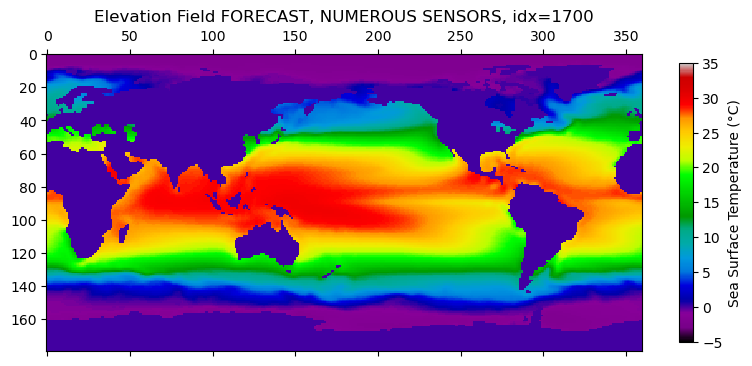

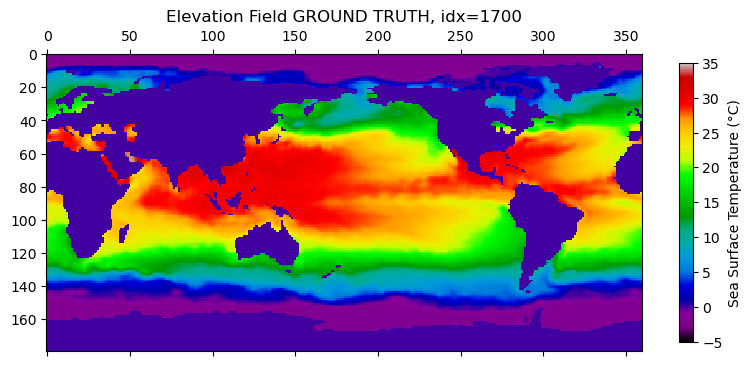

In [14]:
future_index = 0
ground_index = 1700

plt.matshow(sparse_future_reconstruction['Sparse_Future_SST'][0], cmap='nipy_spectral', vmin=-5, vmax=35)
plt.title(f"Elevation Field FORECAST, NUMEROUS SENSORS, idx={ground_index}")
plt.colorbar(label="Sea Surface Temperature (°C)", shrink=0.75)

plt.matshow(data[1700], cmap='nipy_spectral', vmin=-5, vmax=35)
plt.title(f"Elevation Field GROUND TRUTH, idx={ground_index}")
plt.colorbar(label="Sea Surface Temperature (°C)", shrink=0.75)

print(f"MSE of reconstruction: {np.mean((sparse_future_reconstruction['Sparse_Future_SST'][future_index] - data[ground_index])**2)}")

Now run the same comparison using the dense SHRED model instead. Forecasting becomes much more accurate, predicting an SST map far more similar to the ground truth compared to the forecast of the SHRED model trained on sparse data. In conclusion, more well-placed sensors allows SHRED's LSTM encoder to learn a latent representation of the dataset's evolution far better than if less sensors were provided.

MSE of reconstruction: 0.38353607058525085


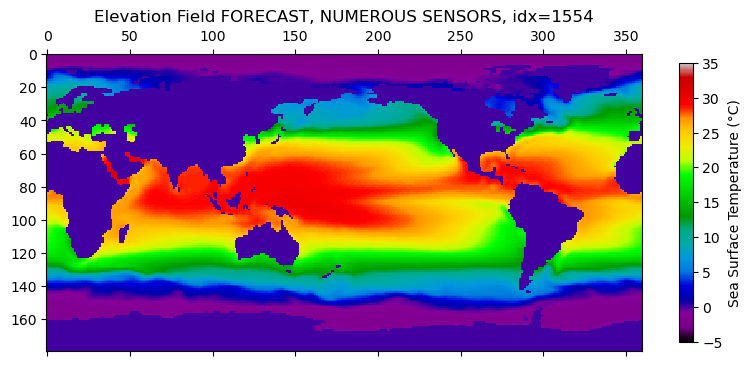

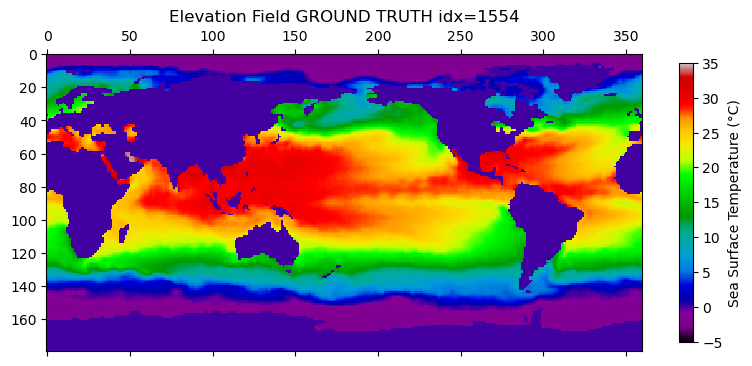

In [15]:
future_index = 0
ground_index = len(data)-dense_future_reconstruction['Dense_Future_SST'].shape[0]

plt.matshow(dense_future_reconstruction['Dense_Future_SST'][0], cmap='nipy_spectral', vmin=-5, vmax=35)
plt.title(f"Elevation Field FORECAST, NUMEROUS SENSORS, idx={ground_index}")
plt.colorbar(label="Sea Surface Temperature (°C)", shrink=0.75)

plt.matshow(data[1700], cmap='nipy_spectral', vmin=-5, vmax=35)
plt.title(f"Elevation Field GROUND TRUTH idx={ground_index}")
plt.colorbar(label="Sea Surface Temperature (°C)", shrink=0.75)

print(f"MSE of reconstruction: {np.mean((dense_future_reconstruction['Dense_Future_SST'][future_index] - data[ground_index])**2)}")

Now construct a video of the entire spatiotemporal dataset, plus the SHRED-forecasted full states (which replace the full states that would normally exist within the bounds of the "testing" data's indices). This way, one can observe if the SHRED-predicted full states are reasonable over time by watching the full states evolve as if watching a video of a real rolling forecast of sea surface temps.

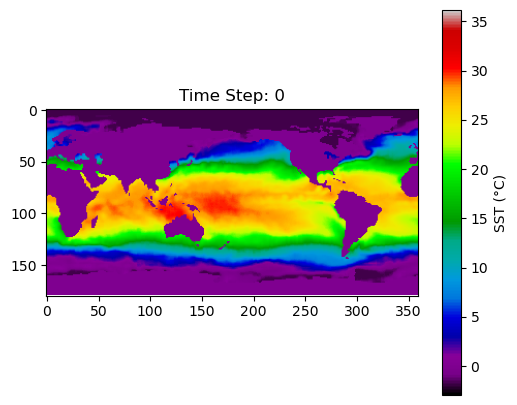

In [16]:
import matplotlib.animation as animation
import numpy as np

animation_limit = 1786
data_sequence = np.vstack((data, dense_future_reconstruction['Dense_Future_SST']))

fig, ax = plt.subplots(figsize=(6, 5))

vmin = np.min(data_sequence)
vmax = np.max(data_sequence)

im = ax.imshow(data_sequence[0], cmap='nipy_spectral', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax, label='SST (°C)')
title = ax.set_title("Time Step: 0")

def update(i):
    im.set_data(data_sequence[i])
    title.set_text(f"Time Step: {i}")
    return im, title

ani = animation.FuncAnimation(fig, update, frames=animation_limit, interval=50, blit=False)

plt.show()
ani.save('sst_reconstruction.gif', writer='pillow', fps=15)

Finally, focus in on the change in data overtime in one spot of the map, comparing the forecaster's prediction to the ground truth. Visually and by looking at the MSE, it's clear that SHRED can capture this change effectively.

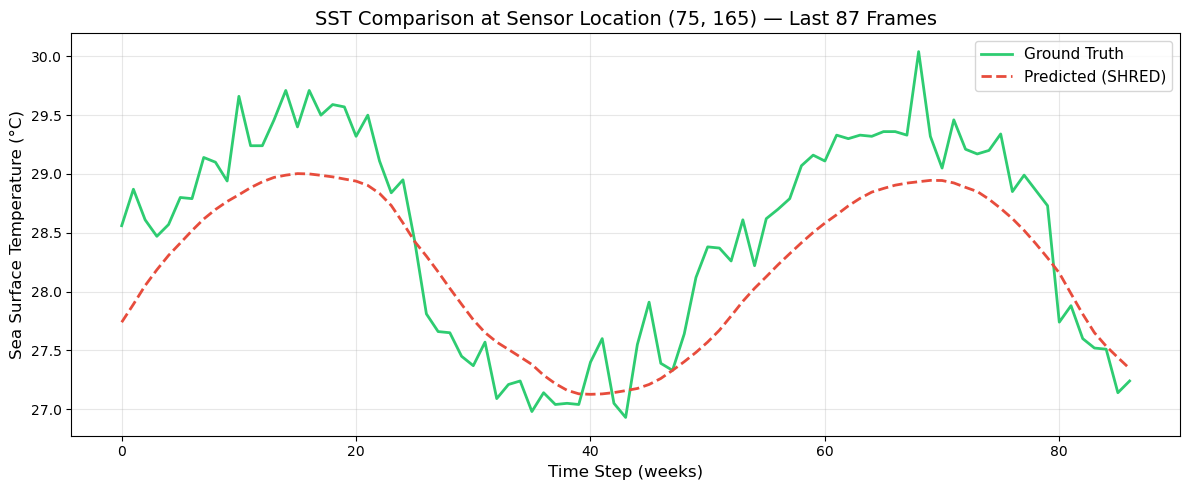

MSE at sensor location (75, 165): 0.2183


In [17]:
# Compare predicted vs ground truth SST at a single sensor location over last 87 frames
num_frames = 87
sensor_location = dense_locations[0]  # Using first sensor at (75, 165)
row, col = sensor_location

# Get the reconstruction data
predicted_data = dense_future_reconstruction['Dense_Future_SST']

# Calculate where the reconstruction aligns with ground truth
ground_truth_start_idx = len(data) - predicted_data.shape[0]

# Extract the last 87 frames from both datasets
predicted_sst = predicted_data[-num_frames:, row, col]
ground_truth_sst = data[ground_truth_start_idx + predicted_data.shape[0] - num_frames:ground_truth_start_idx + predicted_data.shape[0], row, col]

# Create the comparison plot
fig, ax = plt.subplots(figsize=(12, 5))

time_steps = np.arange(num_frames)
ax.plot(time_steps, ground_truth_sst, label='Ground Truth', color='#2ecc71', linewidth=2)
ax.plot(time_steps, predicted_sst, label='Predicted (SHRED)', color='#e74c3c', linewidth=2, linestyle='--')

ax.set_xlabel('Time Step (weeks)', fontsize=12)
ax.set_ylabel('Sea Surface Temperature (°C)', fontsize=12)
ax.set_title(f'SST Comparison at Sensor Location {sensor_location} — Last {num_frames} Frames', fontsize=14)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print MSE for this sensor location
mse_sensor = np.mean((predicted_sst - ground_truth_sst)**2)
print(f"MSE at sensor location {sensor_location}: {mse_sensor:.4f}")
